In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
import pandas as pd
import pickle
from keras import layers, models, Sequential
from keras.callbacks import ModelCheckpoint

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Training Data

In [3]:
file_path = r'.\cifar-100-python\cifar-100-python\train'

with open(file_path, 'rb') as f:
    data_dict = pickle.load(f, encoding='latin1')


print(data_dict.keys()) 


dict_keys(['filenames', 'batch_label', 'fine_labels', 'coarse_labels', 'data'])


In [4]:
data = pd.DataFrame({
    'image_data': list(data_dict['data']),  
    'fine_label': data_dict['fine_labels']  
})

In [5]:
data['image_data'] = data['image_data'].apply(
    lambda x: np.array(x).reshape((3, 32, 32)).transpose(1, 2, 0)
)

In [6]:
df = pd.DataFrame(data)

# Image augmentation
def augment_image(image_array):
    image = tf.convert_to_tensor(image_array, dtype=tf.float32)
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_flip_up_down(image)    # Random vertical flip
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)  # Adjust saturation
    image = tf.image.random_hue(image, max_delta=0.02)  # Adjust hue
    return image.numpy()

# Function to create multiple augmented images for each row
def create_augmented_images(image_array, fine_label, num_augments=2):
    augmented_images = []
    for _ in range(num_augments):
        augmented_images.append({"image_data": augment_image(image_array), "fine_label": fine_label})
    return augmented_images


augmented_data = []
for _, row in df.iterrows():
    augmented_data.extend(create_augmented_images(row["image_data"], row["fine_label"], num_augments=2))


augmented_df = pd.DataFrame(augmented_data)
print(augmented_df.head())

                                          image_data  fine_label
0  [[[130.84698, 170.32404, 85.70657], [103.53876...          19
1  [[[131.95709, 168.40123, 87.90754], [106.76163...          19
2  [[[263.7914, 264.10773, 265.81702], [261.4506,...          29
3  [[[263.5745, 264.0732, 265.1501], [261.2575, 2...          29
4  [[[226.65678, 221.5982, 217.34523], [218.9242,...           0


In [7]:
merged_df = pd.concat([df, augmented_df], ignore_index=True)

In [8]:
merged_df['image_data'] = merged_df['image_data'] / 255.0

In [9]:
merged_df['image_data'] = merged_df['image_data'].map(lambda x: (np.round(x, 2)))

In [10]:
merged_df.shape

(150000, 2)

In [11]:
merged_df['fine_label'].value_counts()

fine_label
19    1500
69    1500
88    1500
32    1500
34    1500
      ... 
81    1500
22    1500
21    1500
65    1500
16    1500
Name: count, Length: 100, dtype: int64

In [12]:
train = merged_df.groupby('fine_label').apply(lambda x: x.sample(1400)).reset_index(drop=True)

In [13]:
images = np.array(train['image_data'].tolist())  # Convert list of 3D arrays to numpy array
labels = np.array(train['fine_label'])  

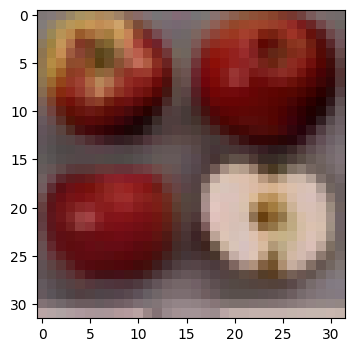

In [14]:
plt.figure(figsize=(4, 4))
plt.imshow(images[2])
plt.show()

In [15]:
remaining_df = merged_df.drop(train.index)

In [16]:
augmented_val_data = []
for _, row in remaining_df.iterrows():
    augmented_val_data.extend(create_augmented_images(row["image_data"], row["fine_label"], num_augments=2))

augmented_val_df = pd.DataFrame(augmented_val_data)

In [17]:
valid = pd.concat([remaining_df, augmented_val_df], ignore_index=True)

In [18]:
valid.shape

(30000, 2)

In [19]:
images_valid = np.array(valid['image_data'].tolist())  # Convert list of 3D arrays to numpy array
labels_valid = np.array(valid['fine_label'])  

In [20]:
file_path = r'cifar-100-python\cifar-100-python\test'

with open(file_path, 'rb') as f:
    test_dict = pickle.load(f, encoding='latin1')

print(test_dict.keys())  

dict_keys(['filenames', 'batch_label', 'fine_labels', 'coarse_labels', 'data'])


In [21]:
test = pd.DataFrame({
    'image_data': list(test_dict['data']),  
    'label': test_dict['fine_labels']  
})

In [22]:
test['image_data'] = test['image_data'].apply(
    lambda x: np.array(x).reshape((3, 32, 32)).transpose(1, 2, 0)
)

In [23]:
test['image_data'] = test['image_data'] / 255.0

In [24]:
test['image_data'] = test['image_data'].map(lambda x: (np.round(x, 2)))

In [25]:
test_images = np.array(test['image_data'].tolist())  # Convert list of 3D arrays to numpy array
test_labels = np.array(test['label'])  

In [26]:
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def modifyNet(input_shape, num_classes=100, num_blocks_list=[2, 2, 2, 2], dropout_rate=0.5):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(128, 3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Adding Dropout layer after the first set of residual blocks
    x = layers.Dropout(dropout_rate)(x)

    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 2 if i > 0 and j == 0 else 1
            x = resnet_block(x, 128 * 2**i, stride=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

In [27]:
input_shape = images.shape[1:]
model = modifyNet(input_shape, 100)

In [28]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 128)  0           ['batch_normalization[0][0]']

In [30]:
model_checkpoint = ModelCheckpoint('ResNet.h5', save_best_only=True, monitor="val_loss")

In [ ]:
training = model.fit(images, labels, batch_size = 32,epochs= 11, validation_data=(images_valid, labels_valid), callbacks=[model_checkpoint])

Epoch 1/50
4375/4375 [==============================] - 364s 81ms/step - loss: 3.2868 - sparse_categorical_accuracy: 0.2029 - val_loss: 2.7699 - val_sparse_categorical_accuracy: 0.3051
Epoch 2/50
4375/4375 [==============================] - 351s 80ms/step - loss: 2.0776 - sparse_categorical_accuracy: 0.4390 - val_loss: 1.8944 - val_sparse_categorical_accuracy: 0.4860
Epoch 3/50
4375/4375 [==============================] - 352s 80ms/step - loss: 1.4476 - sparse_categorical_accuracy: 0.5889 - val_loss: 1.3810 - val_sparse_categorical_accuracy: 0.6042
Epoch 4/50
4375/4375 [==============================] - 352s 80ms/step - loss: 0.9639 - sparse_categorical_accuracy: 0.7145 - val_loss: 1.0452 - val_sparse_categorical_accuracy: 0.7004
Epoch 5/50
4375/4375 [==============================] - 352s 80ms/step - loss: 0.5774 - sparse_categorical_accuracy: 0.8227 - val_loss: 0.7597 - val_sparse_categorical_accuracy: 0.7833
Epoch 6/50
4375/4375 [==============================] - 351s 80ms/step - lo

KeyboardInterrupt: 

In [35]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(images)

In [36]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
training2 = model.fit(datagen.flow(images, labels, batch_size=32),epochs= 10, validation_data=(images_valid, labels_valid), callbacks=[model_checkpoint])

Epoch 1/10
4375/4375 [==============================] - 357s 81ms/step - loss: 1.1225 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.4620 - val_sparse_categorical_accuracy: 0.8968
Epoch 2/10
4375/4375 [==============================] - 355s 81ms/step - loss: 0.9095 - sparse_categorical_accuracy: 0.7634 - val_loss: 0.4204 - val_sparse_categorical_accuracy: 0.8969
Epoch 3/10
4375/4375 [==============================] - 355s 81ms/step - loss: 0.7971 - sparse_categorical_accuracy: 0.7800 - val_loss: 0.4007 - val_sparse_categorical_accuracy: 0.8958
Epoch 4/10
4375/4375 [==============================] - 355s 81ms/step - loss: 0.7266 - sparse_categorical_accuracy: 0.7921 - val_loss: 0.3816 - val_sparse_categorical_accuracy: 0.8993
Epoch 5/10
4375/4375 [==============================] - 356s 81ms/step - loss: 0.6780 - sparse_categorical_accuracy: 0.8026 - val_loss: 0.3829 - val_sparse_categorical_accuracy: 0.8973
Epoch 6/10
4375/4375 [==============================] - 355s 81ms/step - lo

In [47]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(images)

In [56]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
training3 = model.fit(datagen.flow(images, labels, batch_size=32),epochs= 5, validation_data=(images_valid, labels_valid), callbacks=[model_checkpoint])

Epoch 1/5
4375/4375 [==============================] - 357s 81ms/step - loss: 0.3835 - sparse_categorical_accuracy: 0.8831 - val_loss: 0.2851 - val_sparse_categorical_accuracy: 0.9198
Epoch 2/5
4375/4375 [==============================] - 355s 81ms/step - loss: 0.3579 - sparse_categorical_accuracy: 0.8907 - val_loss: 0.2725 - val_sparse_categorical_accuracy: 0.9237
Epoch 3/5
4375/4375 [==============================] - 355s 81ms/step - loss: 0.3349 - sparse_categorical_accuracy: 0.8974 - val_loss: 0.2605 - val_sparse_categorical_accuracy: 0.9278
Epoch 4/5
4375/4375 [==============================] - 359s 82ms/step - loss: 0.3119 - sparse_categorical_accuracy: 0.9051 - val_loss: 0.2654 - val_sparse_categorical_accuracy: 0.9271
Epoch 5/5
4375/4375 [==============================] - 357s 82ms/step - loss: 0.2959 - sparse_categorical_accuracy: 0.9086 - val_loss: 0.2480 - val_sparse_categorical_accuracy: 0.9313


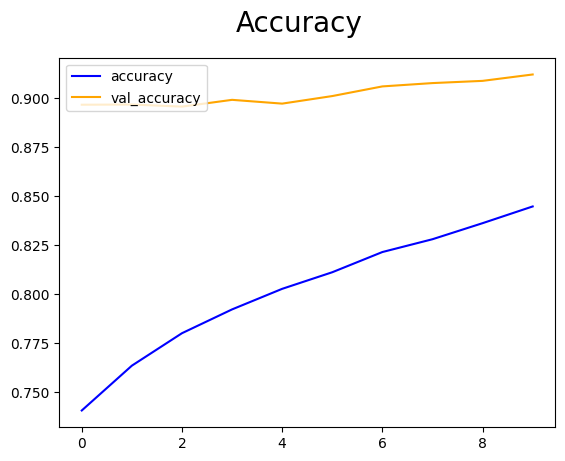

In [37]:
fig = plt.figure()
plt.plot(training2.history['sparse_categorical_accuracy'], color='blue', label='accuracy')
plt.plot(training2.history['val_sparse_categorical_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

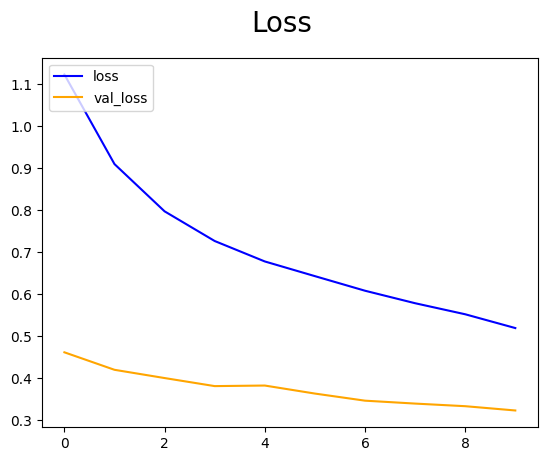

In [38]:
fig = plt.figure()
plt.plot(training2.history['loss'], color='blue', label='loss')
plt.plot(training2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Test Data

In [58]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 7s 22ms/step - loss: 1.6723 - sparse_categorical_accuracy: 0.6550


[1.6722830533981323, 0.6549999713897705]

In [50]:
test_pred = model.predict(test_images)

In [51]:
test_pred = test_pred.argmax(axis=-1)

In [52]:
f1_class = f1_score(test_labels, test_pred,average=None)
print(f1_class)

[0.85128205 0.78947368 0.49473684 0.39473684 0.37373737 0.67555556
 0.73170732 0.68493151 0.73275862 0.76767677 0.44102564 0.46808511
 0.65       0.62244898 0.61111111 0.61764706 0.657277   0.84
 0.57843137 0.64321608 0.82568807 0.80851064 0.62222222 0.77348066
 0.81443299 0.54644809 0.60683761 0.42285714 0.74747475 0.65263158
 0.61928934 0.63953488 0.68539326 0.61410788 0.64088398 0.41304348
 0.74157303 0.65686275 0.53038674 0.80717489 0.60416667 0.80808081
 0.47318612 0.73033708 0.35652174 0.45128205 0.43601896 0.64628821
 0.80168776 0.77386935 0.41463415 0.62068966 0.59903382 0.80555556
 0.75       0.34224599 0.87096774 0.6961326  0.82291667 0.66315789
 0.8195122  0.63302752 0.68965517 0.54358974 0.44919786 0.39506173
 0.59813084 0.54545455 0.86772487 0.78688525 0.67073171 0.72340426
 0.31168831 0.56701031 0.47058824 0.82692308 0.82178218 0.62637363
 0.48461538 0.76923077 0.46451613 0.6796875  0.91282051 0.65497076
 0.60913706 0.77720207 0.57489879 0.73043478 0.70222222 0.70813397
 

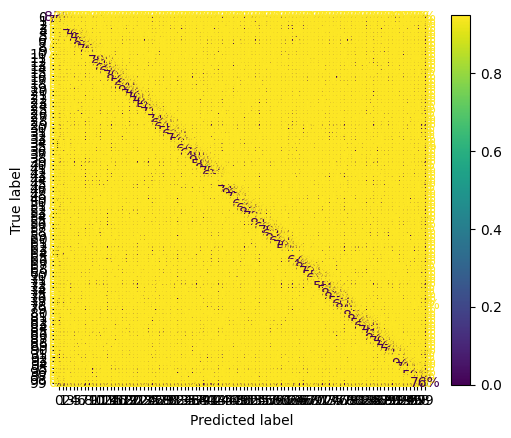

In [53]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_pred, normalize='true', values_format='.0%')

In [54]:
import os

In [55]:
model.save(os.path.join('models','ResNet.h5'))